In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

DATA_PATH = "/content/drive/MyDrive/project/data/"

In [3]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
sub = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [4]:
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [6]:
test.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [12]:
train.shape , test.shape , sub.shape

((204000, 10), (16800, 7), (16800, 2))

In [27]:
train.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도', '일조', '일사', 'target']
test.columns = ['num_date_time', 'num', 'date_time', '기온', '강수량', '풍속', '습도']

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   num            204000 non-null  int64  
 2   date_time      204000 non-null  object 
 3   기온             204000 non-null  float64
 4   강수량            43931 non-null   float64
 5   풍속             203981 non-null  float64
 6   습도             203991 non-null  float64
 7   일조             128818 non-null  float64
 8   일사             116087 non-null  float64
 9   target         204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   num            16800 non-null  int64  
 2   date_time      16800 non-null  object 
 3   기온             16800 non-null  float64
 4   강수량            16800 non-null  float64
 5   풍속             16800 non-null  float64
 6   습도             16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [31]:
sns.set_style('whitegrid')

In [32]:
eda_df = train.copy()

In [33]:
# adding features related to datetime
eda_df['date_time'] = pd.to_datetime(eda_df['date_time'])
eda_df['hour'] = eda_df['date_time'].dt.hour
eda_df['weekday'] = eda_df['date_time'].dt.weekday
eda_df['date'] = eda_df['date_time'].dt.date
eda_df['day'] = eda_df['date_time'].dt.day
eda_df['month'] = eda_df['date_time'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

In [34]:
eda_df.head()

,num_date_time,num,date_time,기온,강수량,풍속,습도,일조,일사,target,hour,weekday,date,day,month,weekend
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,0,2,2022-06-01,1,6,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,1,2,2022-06-01,1,6,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,2,2,2022-06-01,1,6,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,3,2,2022-06-01,1,6,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,4,2,2022-06-01,1,6,0


<Axes: >

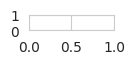

In [40]:
plt.subplot(20, 5, 100)

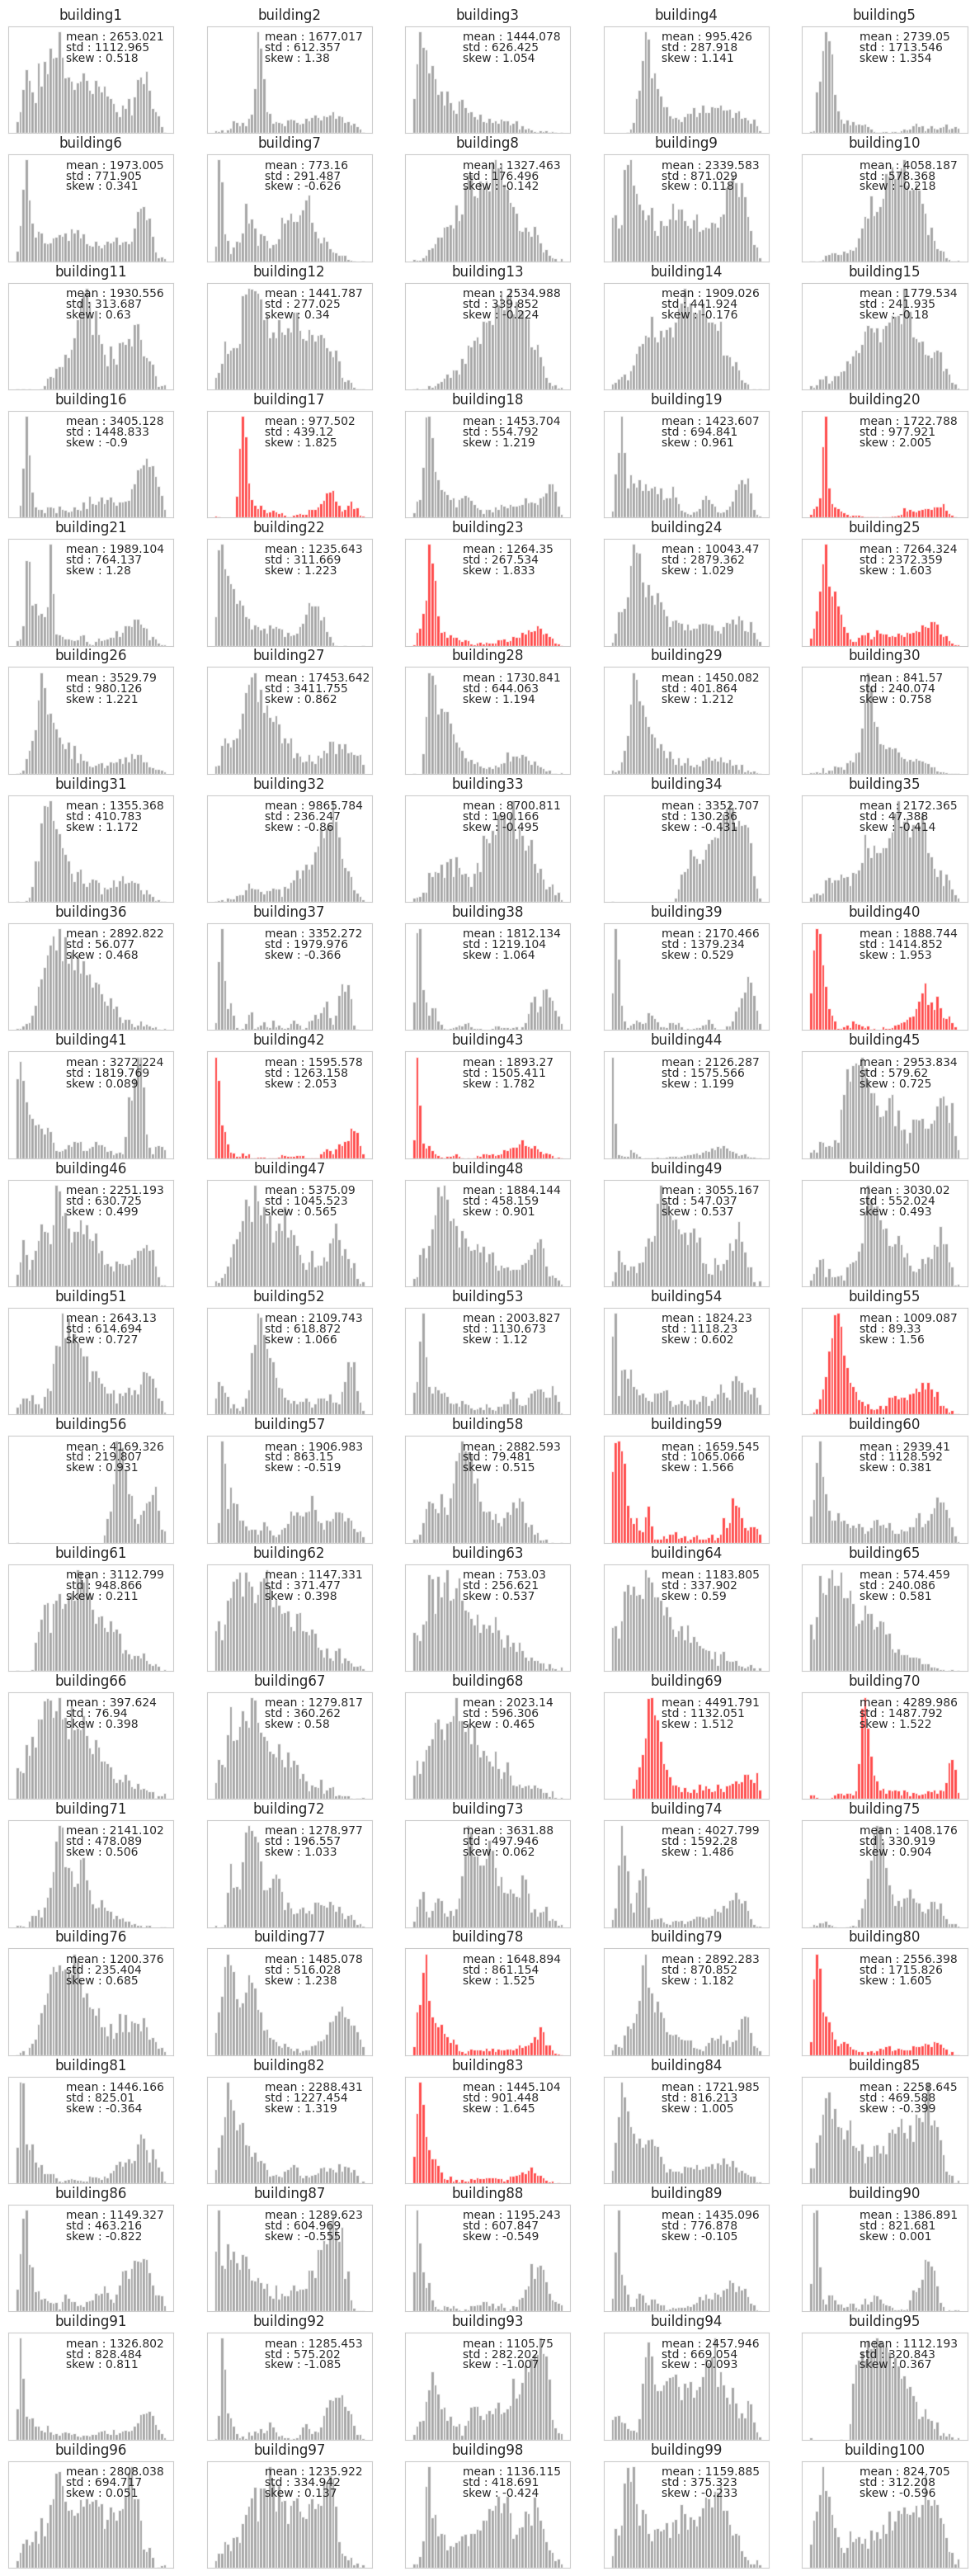

In [41]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(20, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

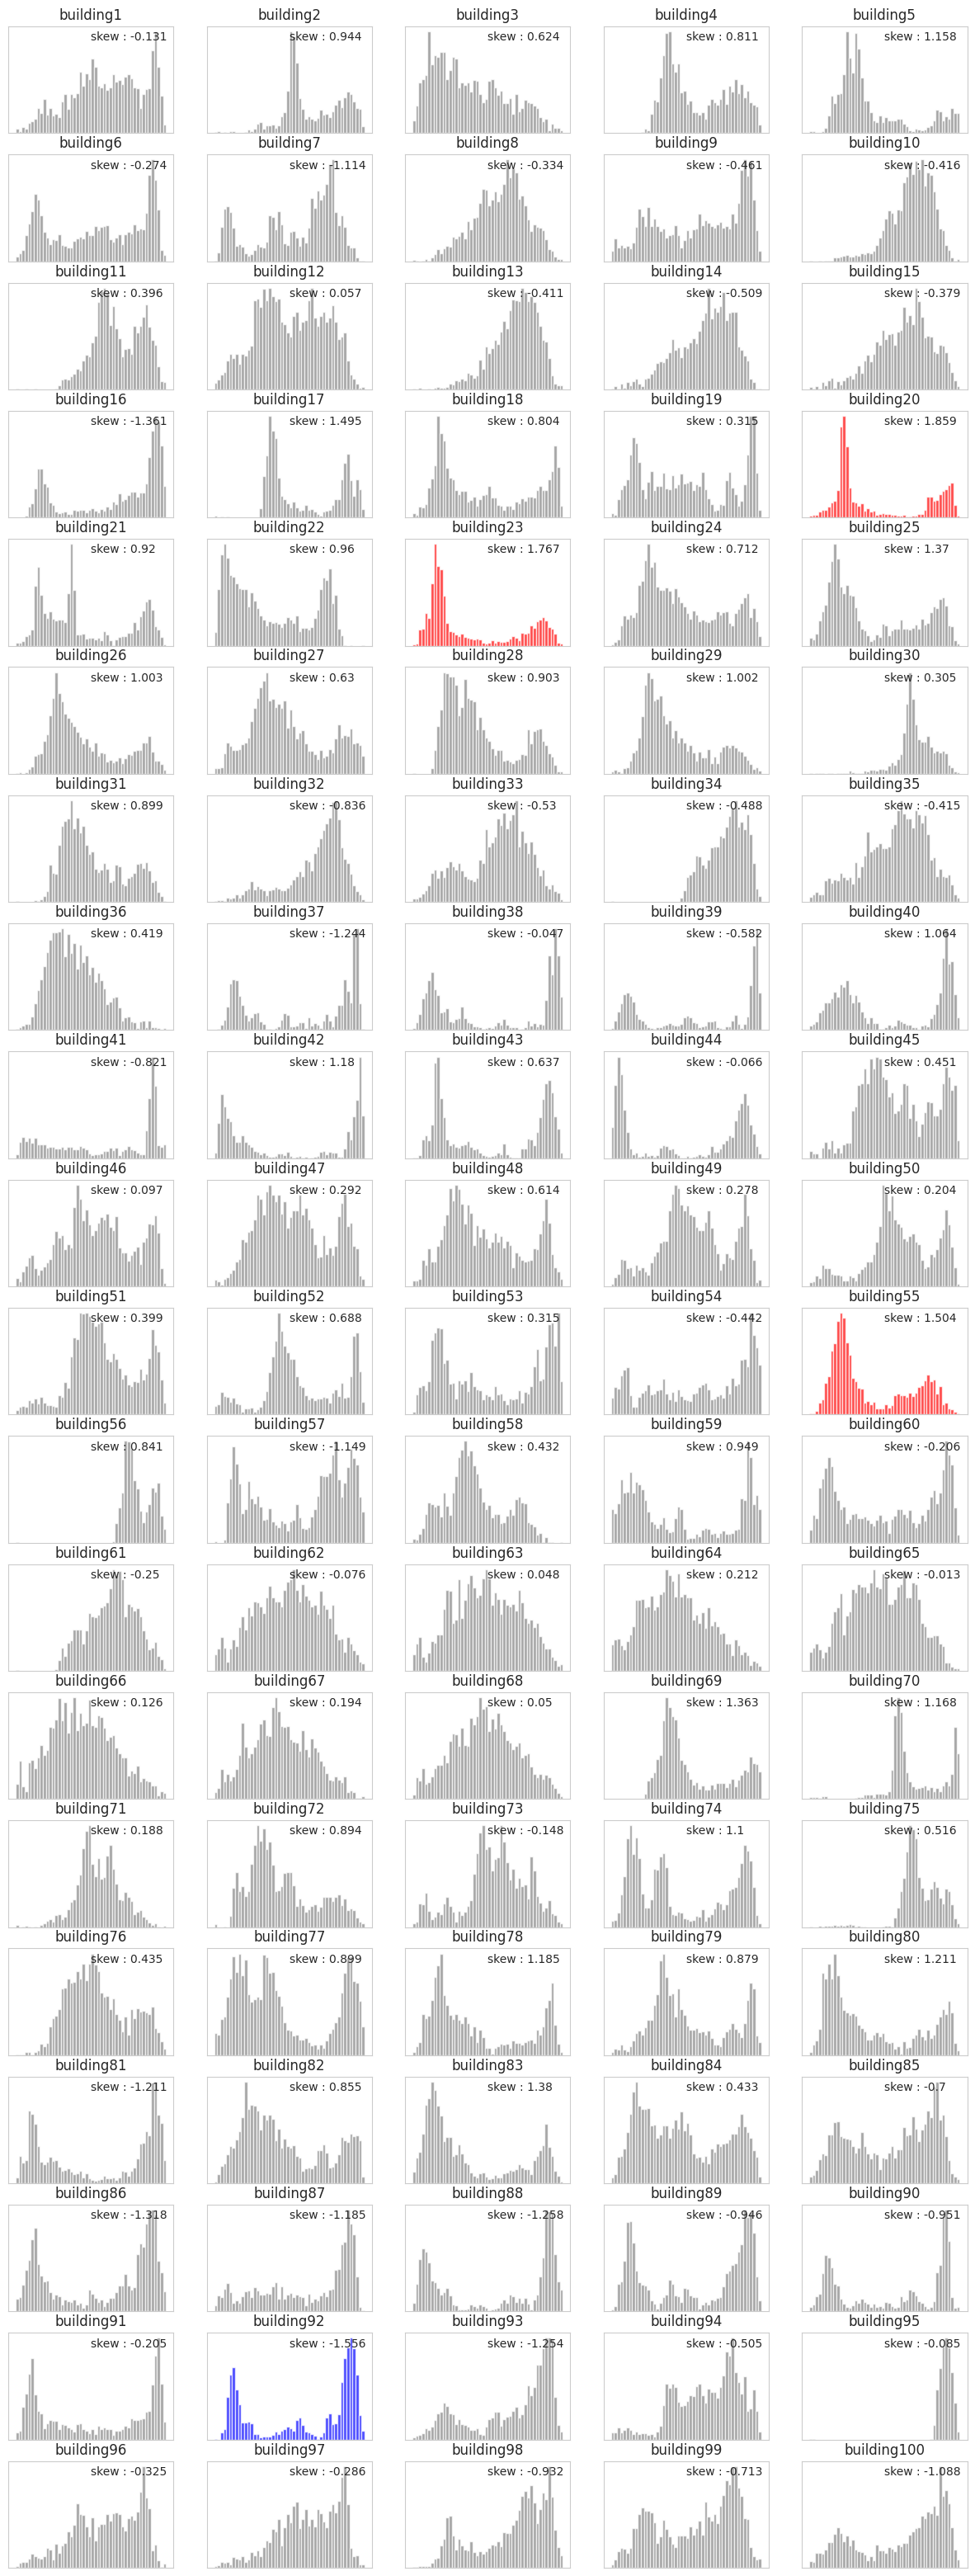

In [42]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,101):
    ax = plt.subplot(20, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [44]:
# 로그 변환을 통해 왜도값이 줄어듦을 확인했으니, target을 로그변환한 값으로 학습해야 함
# 추론 시에는 모델 예측값에 역로그 변환(exponential)을 적용해야 함

# 모델의 로그 변환된 예측값
# log_pred = 2.0

# 역 로그 변환 (exponential)
# original_pred = np.exp(log_pred)

# 모델 검토

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor